In [10]:
import warnings
warnings.filterwarnings("ignore")

## 导入数据

In [1]:
import os
import zipfile
from scipy.io import loadmat

mnist_zip_path = os.path.join(os.getcwd(), "data/mnist-original.zip")
mnist_mat_path = os.path.join(os.getcwd(), "data/mnist-original.mat")
mnistzip = zipfile.ZipFile(mnist_zip_path, "r") 
if not os.path.exists(mnist_mat_path):
    mnistzip.extractall()
mnistzip.close()
mnist = loadmat(mnist_mat_path)
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [23]:
X, y = mnist["data"].T, mnist["label"].T
X.shape, y.shape

((70000, 784), (70000, 1))

MNIST 有 70000 张图片，每张图片有 784 个特征。这是因为每个图片都是28*28像素的，并且每个像素的值介于 0~255 之间。让我们看一看数据集的某一个数字。你只需要将某个实例的特征向量，reshape为28*28的数组，然后使用 Matplotlib 的imshow函数展示出来。

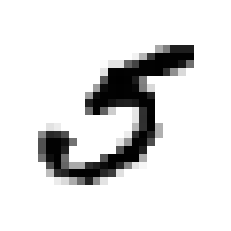

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [25]:
 y[36000]

array([5.])

## 拆分数据集
你总是应该先创建测试集，并且在验证数据之前先把测试集晾到一边。MNIST 数据集已经事先被分成了一个训练集（前 60000 张图片）和一个测试集（最后 10000 张图片）

In [26]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

让我们打乱训练集。这可以保证交叉验证的每一折都是相似（你不会期待某一折缺少某类数字）。而且，一些学习算法对训练样例的顺序敏感，当它们在一行当中得到许多相似的样例，这些算法将会表现得非常差。打乱数据集将保证这种情况不会发生。

In [27]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 训练一个二分类器 
现在我们简化一下问题，只尝试去识别一个数字，比如说，数字 5。这个“数字 5 检测器”就是一个二分类器，能够识别两类别，“是 5”和“非 5”。让我们为这个分类任务创建目标向量：

In [28]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)
y_train_5

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

现在让我们挑选一个分类器去训练它。用随机梯度下降分类器 SGD，是一个不错的开始。使用 Scikit-Learn 的SGDClassifier类。这个分类器有一个好处是能够高效地处理非常大的数据集。这部分原因在于SGD一次只处理一条数据，这也使得 SGD 适合在线学习（online learning）。我们在稍后会看到它。让我们创建一个SGDClassifier和在整个数据集上训练它。

In [29]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

SGDClassifier依赖于训练集的随机程度（所以被命名为 stochastic，随机之义）。如果你想重现结果，你应该固定参数random_state
现在你可以用它来查出数字 5 的图片。

In [10]:
y[36000-1], y[36000], y[36000-2], y[36000-3]

(array([5.]), array([5.]), array([5.]), array([5.]))

In [11]:
sgd_clf.predict([X[36000-2]]),sgd_clf.predict([X[36000-3]])

(array([ True]), array([False]))

In [12]:
sgd_clf.predict([some_digit])

array([ True])

## 对性能的评估
评估一个分类器，通常比评估一个回归器更加玄学。所以我们将会花大量的篇幅在这个话题上。有许多度量性能的方法，所以拿来一杯咖啡和准备学习许多新概念和首字母缩略词吧。

## 使用交叉验证测量准确性
评估一个模型的好方法是使用交叉验证，就像第二章所做的那样。

**实现交叉验证**

在交叉验证过程中，有时候你会需要更多的控制权，相较于函数cross_val_score()或者其他相似函数所提供的功能。这种情况下，你可以实现你自己版本的交叉验证。事实上它相当简单。以下代码粗略地做了和cross_val_score()相同的事情，并且输出相同的结果。


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
   clone_clf = clone(sgd_clf)
   X_train_folds = X_train[train_index]
   y_train_folds = (y_train_5[train_index])
   X_test_fold = X_train[test_index]
   y_test_fold = (y_train_5[test_index])
   clone_clf.fit(X_train_folds, y_train_folds)
   y_pred = clone_clf.predict(X_test_fold)
   n_correct = sum(y_pred == y_test_fold)
   print(n_correct / len(y_pred))

[0.90965 0.09035 0.90965 ... 0.09035 0.09035 0.09035]
[0.90965 0.90965 0.90965 ... 0.90965 0.09035 0.90965]
[0.90965 0.90965 0.90965 ... 0.90965 0.90965 0.90965]


StratifiedKFold类实现了分层采样（详见第二章的解释），生成的折（fold）包含了各类相应比例的样例。在每一次迭代，上述代码生成分类器的一个克隆版本，在训练折（training folds）的克隆版本上进行训，在测试折（test folds）上进行预测。然后它计算出被正确预测的数目和输出正确预测的比例。

让我们使用cross_val_score()函数来评估SGDClassifier模型，同时使用 K 折交叉验证，此处让k=3。记住：K 折交叉验证意味着把训练集分成 K 折（此处 3 折），然后使用一个模型对其中一折进行预测，对其他折进行训练。
。

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96965, 0.9602 , 0.9657 ])

哇！在交叉验证上有大于 95% 的精度（accuracy）？这看起来很令人吃惊。先别高兴，让我们来看一个非常笨的分类器去分类，看看其在“非 5”这个类上的表现。

In [15]:
import numpy as np
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91025, 0.91145, 0.90725])

没错，这个笨的分类器也有 90% 的精度。这是因为只有 10% 的图片是数字 5，所以你总是猜测某张图片不是 5，你也会有90%的可能性是对的。

这证明了为什么精度通常来说不是一个好的性能度量指标，特别是当你处理有偏差的数据集，比方说其中一些类比其他类频繁得多。

混淆矩阵
对分类器来说，一个好得多的性能评估指标是混淆矩阵。大体思路是：输出类别A被分类成类别 B 的次数。举个例子，为了知道分类器将 5 误分为 3 的次数，你需要查看混淆矩阵的第五行第三列。

为了计算混淆矩阵，首先你需要有一系列的预测值，这样才能将预测值与真实值做比较。你或许想在测试集上做预测。但是我们现在先不碰它。（记住，只有当你处于项目的尾声，当你准备上线一个分类器的时候，你才应该使用测试集）。相反，你应该使用cross_val_predict()函数

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([False,  True, False, ..., False, False, False])

就像 cross_val_score()，cross_val_predict()也使用 K 折交叉验证。它不是返回一个评估分数，而是返回基于每一个测试折做出的一个预测值。这意味着，对于每一个训练集的样例，你得到一个干净的预测（“干净”是说一个模型在训练过程当中没有用到测试集的数据）。

现在使用 confusion_matrix()函数，你将会得到一个混淆矩阵。传递目标类(y_train_5)和预测类（y_train_pred）给它。


In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53853,   726],
       [ 1363,  4058]], dtype=int64)

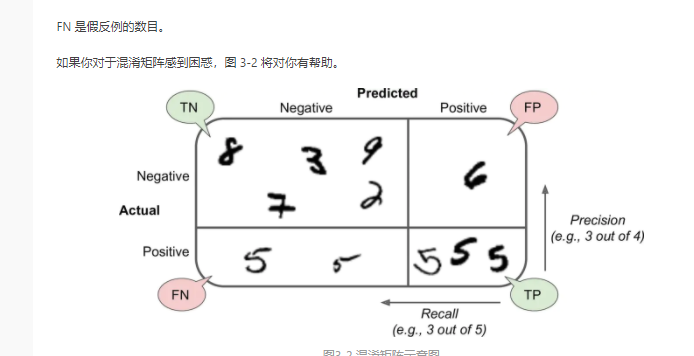
混淆矩阵中的每一行表示一个实际的类, 而每一列表示一个预测的类。该矩阵的第一行认为“非 5”（反例）中的 53853 张被正确归类为 “非 5”（他们被称为真反例，true negatives）, 而其余 726 被错误归类为"是 5" （假正例，false positives）。第二行认为“是 5” （正例）中的 1363 被错误地归类为“非 5”（假反例，false negatives），其余 4058 正确分类为 “是 5”类（真正例，true positives）。一个完美的分类器将只有真反例和真正例，所以混淆矩阵的非零值仅在其主对角线（左上至右下）。

## 准确率与召回率

In [18]:
import math
import latexify

In [21]:
@latexify.with_latex
def precision():
    return  TP/(TP + FP)
precision

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x24fd33f9a58>

其中 TP 是真正例的数目，FP 是假正例的数目。

想要一个完美的准确率，一个繁复的方法是构造一个单一正例的预测和，并确保这个预测是正确的（precision = 1/1 = 100%）。但是这什么用，因为分类器会忽略所有样例，除了那一个正例。所以准确率一般会伴随另一个指标一起使用，这个指标叫做召回率（recall），也叫做敏感度（sensitivity）或者真正例率（true positive rate， TPR）。这是正例被分类器正确探测出的比率。

In [20]:
@latexify.with_latex
def recall():
    return TP/(TP+FN)
recall

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x23514195668>

FN 是假反例的数目。

Scikit-Learn 提供了一些函数去计算分类器的指标，包括准确率和召回率。

In [21]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 4344 / (4344 + 1307)
print(recall_score(y_train_5, y_train_pred)) # == 4344 / (4344 + 1077)

0.8482441471571907
0.748570374469655


当你去观察精度的时候，你的“数字 5 探测器”看起来还不够好。当它声明某张图片是 5 的时候，它只有 77% 的可能性是正确的。而且，它也只检测出“是 5”类图片当中的 79%。

通常结合准确率和召回率会更加方便，这个指标叫做“F1 值”，特别是当你需要一个简单的方法去比较两个分类器的优劣的时候。F1 值是准确率和召回率的调和平均。普通的平均值平等地看待所有的值，而调和平均会给小的值更大的权重。所以，要想分类器得到一个高的 F1 值，需要召回率和准确率同时高。

In [22]:
@latexify.with_latex
def F1():
    return 2/((1/precision) + (1/recall))
F1                                                                                        

<latexify.core.with_latex.<locals>._LatexifiedFunction at 0x235141959e8>

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7952964233219011

F1 支持那些有着相近准确率和召回率的分类器。这不会总是你想要的。有的场景你会更关心准确率，而另外一些场景你会更关心召回率。举例，如果你训练一个分类器去检测视频是否适合儿童观看，你会倾向选择那种即便拒绝了很多好视频、但保证所保留的视频都是好（高准确率）的分类器，而不是那种高召回率、但让坏视频混入的分类器（这种情况下你或许想增加人工去检测分类器选择出来的视频）。另一方面，加入你训练一个分类器去检测监控图像当中的窃贼，有着 30% 准确率、99% 召回率的分类器或许是合适的（当然，警卫会得到一些错误的报警，但是几乎所有的窃贼都会被抓到）。

不幸的是，你不能同时拥有两者。增加准确率会降低召回率，反之亦然。这叫做准确率与召回率之间的折衷。


## 准确率/召回率之间的折衷
为了弄懂这个折衷，我们看一下SGDClassifier是如何做分类决策的。对于每个样例，它根据决策函数计算分数,如果这个分数大于一个阈值，它会将样例分配给正例，否则它将分配给反例。图 3-3 显示了几个数字从左边的最低分数排到右边的最高分。假设决策阈值位于中间的箭头（介于两个 5 之间）：您将发现4个真正例（数字 5）和一个假正例（数字 6）在该阈值的右侧。因此,使用该阈值,准确率为 80%（4/5）。但实际有 6 个数字 5，分类器只检测 4 个, 所以召回是 67% （4/6）。现在，如果你
提高阈值（移动到右侧的箭头），假正例（数字 6）成为一个真反例，从而提高准确率（在这种情况下高达 100%），但一个真正例 变成假反例，召回率降低到 50%。相反，降低阈值可提高召回率、降低准确率。

Scikit-Learn 不让你直接设置阈值，但是它给你提供了设置决策分数的方法，这个决策分数可以用来产生预测。它不是调用分类器的predict()方法，而是调用decision_function()方法。这个方法返回每一个样例的分数值，然后基于这个分数值，使用你想要的任何阈值做出预测。

In [24]:
y_scores = sgd_clf.decision_function([X[36000]])
y_scores

array([968.09188378])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([ True])

In [26]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred 

array([False])

这证明了提高阈值会降调召回率。这个图片实际就是数字 5，当阈值等于 0 的时候，分类器可以探测到这是一个 5，当阈值提高到 20000 的时候，分类器将不能探测到这是数字 5。

那么，你应该如何使用哪个阈值呢？首先，你需要再次使用cross_val_predict()得到每一个样例的分数值，但是这一次指定返回一个决策分数，而不是预测值。

In [13]:
y_scores = sgd_clf.decision_function(X_train)
y_scores

array([-12176.16696692,  -8718.95137039,  -8827.63153824, ...,
        -7929.4921539 ,  -6699.58913175,  -2747.18354128])

现在有了这些分数值。对于任何可能的阈值，使用precision_recall_curve(),你都可以计算准确率和召回率:

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
precisions, recalls, thresholds.shape

(array([0.0905099 , 0.09049472, 0.09049623, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99815532e-01, 9.99815532e-01, ...,
        3.68935621e-04, 1.84467810e-04, 0.00000000e+00]),
 (59894,))

最后，你可以使用 Matplotlib 画出准确率和召回率， 这里把准确率和召回率当作是阈值的一个函数。

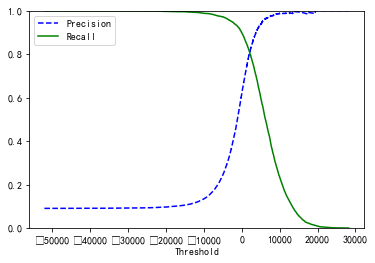

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

你也许会好奇为什么准确率曲线比召回率曲线更加起伏不平。原因是准确率有时候会降低，尽管当你提高阈值的时候，通常来说准确率会随之提高。回头看图 3-3，留意当你从中间箭头开始然后向右移动一个数字会发生什么： 准确率会由 4/5（80%）降到 3/4（75%）。另一方面，当阈值提高时候，召回率只会降低。这也就说明了为什么召回率的曲线更加平滑。

现在你可以选择适合你任务的最佳阈值。另一个选出好的准确率/召回率折衷的方法是直接画出准确率对召回率的曲线，如图 3-5 所示。
。

Text(0,0.5,'precision')

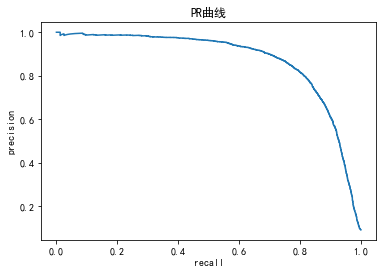

In [30]:
plt.plot(recalls, precisions)
plt.title("PR曲线")
plt.xlabel("recall")
plt.ylabel("precision")

可以看到，在召回率在 80% 左右的时候，准确率急剧下降。你可能会想选择在急剧下降之前选择出一个准确率/召回率折衷点。比如说，在召回率 60% 左右的点。当然，这取决于你的项目需求。

我们假设你决定达到 90% 的准确率。你查阅第一幅图（放大一些），在 70000 附近找到一个阈值。为了作出预测（目前为止只在训练集上预测），你可以运行以下代码，而不是运行分类器的predict()方法。

In [31]:
y_train_pred_90 = (y_scores > 70000)

In [32]:
precision_score(y_train_5, y_train_pred_90)

0.0

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.0

In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_train_5, sgd_clf.predict(X_train)))

              precision    recall  f1-score   support

       False       0.99      0.94      0.97     54579
        True       0.62      0.90      0.73      5421

    accuracy                           0.94     60000
   macro avg       0.80      0.92      0.85     60000
weighted avg       0.96      0.94      0.95     60000



## ROC 曲线
受试者工作特征（ROC）曲线是另一个二分类器常用的工具。它非常类似于准确率/召回率曲线，但不是画出准确率对召回率的曲线，ROC 曲线是真正例率（true positive rate，另一个名字叫做召回率）对假正例率（false positive rate, FPR）的曲线。FPR 是反例被错误分成正例的比率。它等于 1 减去真反例率（true negative rate， TNR）。TNR是反例被正确分类的比率。TNR也叫做特异性。所以 ROC 曲线画出召回率对（1 减特异性）的曲线。<br>
从列联表引入两个新名词。其一是真正类率(true positive rate ,TPR), 计算公式为<br>

$$ TPR = \frac{TP}{TP + FN}$$

刻画的是分类器所识别出的 正实例占所有正实例的比例。

　　另外一个是负正类率(false positive rate, FPR),计算公式为

$$ FPR = \frac{FP}{FP + TN}$$

计算的是分类器错认为正类的负实例占所有负实例的比例。

　　还有一个真负类率（True Negative Rate，TNR），也称为specificity，计算公式为

$$TNR = \frac{TN}{FP + TN} = 1 - FPR$$
为了画出 ROC 曲线，你首先需要计算各种不同阈值下的 TPR、FPR，使用roc_curve()函数

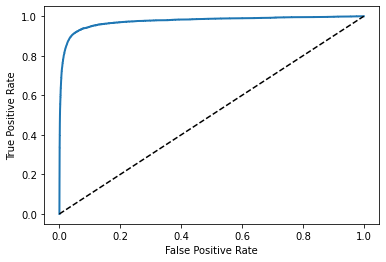

In [14]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
   # plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

这里同样存在折衷的问题：召回率（TPR）越高，分类器就会产生越多的假正例（FPR）。图中的点线是一个完全随机的分类器生成的 ROC 曲线；一个好的分类器的 ROC 曲线应该尽可能远离这条线（即向左上角方向靠拢）。

一个比较分类器优劣的方法是：测量ROC曲线下的面积（AUC，area under the curve）。一个完美的分类器的 ROC AUC 等于 1，而一个纯随机分类器的 ROC AUC 等于 0.5。Scikit-Learn 提供了一个函数来计算 ROC AUC：

In [15]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9744591390382107

因为 ROC 曲线跟准确率/召回率曲线（或者叫 PR）很类似，你或许会好奇如何决定使用哪一个曲线呢？一个笨拙的规则是，当正例很少，或者当你关注假正例多于假反例的时候，优先使用 PR 曲线。其他情况使用 ROC 曲线。举例子，回顾前面的 ROC 曲线和 ROC AUC 数值，你或许认为这个分类器很棒。但是这几乎全是因为只有少数正例（“是 5”），而大部分是反例（“非 5”）。相反，PR 曲线清楚显示出这个分类器还有很大的改善空间（PR 曲线应该尽可能地靠近右上角）。

让我们训练一个RandomForestClassifier，然后拿它的的ROC曲线和ROC AUC数值去跟SGDClassifier的比较。首先你需要得到训练集每个样例的数值。但是由于随机森林分类器的工作方式，RandomForestClassifier不提供decision_function()方法。相反，它提供了predict_proba()方法。Skikit-Learn分类器通常二者中的一个。predict_proba()方法返回一个数组，数组的每一行代表一个样例，每一列代表一个类。数组当中的值的意思是：给定一个样例属于给定类的概率。比如，70%的概率这幅图是数字 5。

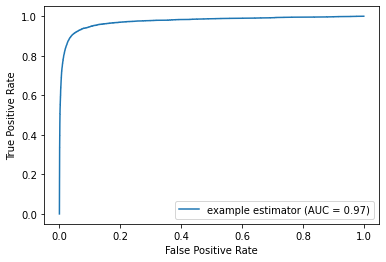

In [16]:
import matplotlib.pyplot as plt  # doctest: +SKIP
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train_5, y_scores)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()  # doctest: +SKIP
plt.show()      # doctest: +SKIP

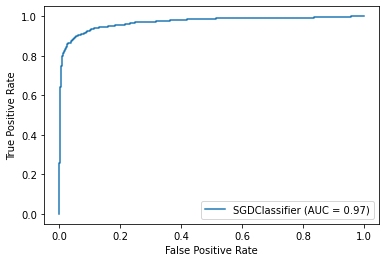

In [33]:
>>> import matplotlib.pyplot as plt  # doctest: +SKIP
>>> from sklearn import datasets, metrics
>>> metrics.plot_roc_curve(sgd_clf, X_test, y_test_5)  # doctest: +SKIP
>>> plt.show()           

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_proba = forest_clf.fit(X_train, y_train_5).predict_proba(X_train) 

但是要画 ROC 曲线，你需要的是样例的分数，而不是概率。一个简单的解决方法是使用正例的概率当作样例的分数。

In [38]:
y_scores_forest = y_proba[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

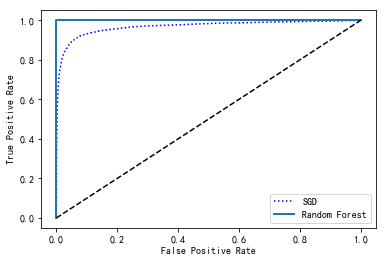

In [39]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

如你所见，RandomForestClassifier的 ROC 曲线比SGDClassifier的好得多：它更靠近左上角。所以，它的 ROC AUC 也会更大。

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

1.0

In [41]:
y_train_f_pred = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [42]:
print(precision_score(y_train_5, y_train_f_pred)) # == 4344 / (4344 + 1307)
print(recall_score(y_train_5, y_train_f_pred))

0.9909473684210526
0.8682899833978971


## 多类分类

二分类器只能区分两个类，而多类分类器（也被叫做多项式分类器）可以区分多于两个类。

一些算法（比如随机森林分类器或者朴素贝叶斯分类器）可以直接处理多类分类问题。其他一些算法（比如 SVM 分类器或者线性分类器）则是严格的二分类器。然后，有许多策略可以让你用二分类器去执行多类分类。

举例子，创建一个可以将图片分成 10 类（从 0 到 9）的系统的一个方法是：训练10个二分类器，每一个对应一个数字（探测器 0，探测器 1，探测器 2，以此类推）。然后当你想对某张图片进行分类的时候，让每一个分类器对这个图片进行分类，选出决策分数最高的那个分类器。这叫做“一对所有”（OvA）策略（也被叫做“一对其他”）。

另一个策略是对每一对数字都训练一个二分类器：一个分类器用来处理数字 0 和数字 1，一个用来处理数字 0 和数字 2，一个用来处理数字 1 和 2，以此类推。这叫做“一对一”（OvO）策略。如果有 N 个类。你需要训练N*(N-1)/2个分类器。对于 MNIST 问题，需要训练 45 个二分类器！当你想对一张图片进行分类，你必须将这张图片跑在全部45个二分类器上。然后看哪个类胜出。OvO 策略的主要有点是：每个分类器只需要在训练集的部分数据上面进行训练。这部分数据是它所需要区分的那两个类对应的数据。

一些算法（比如 SVM 分类器）在训练集的大小上很难扩展，所以对于这些算法，OvO 是比较好的，因为它可以在小的数据集上面可以更多地训练，较之于巨大的数据集而言。但是，对于大部分的二分类器来说，OvA 是更好的选择。

Scikit-Learn 可以探测出你想使用一个二分类器去完成多分类的任务，它会自动地执行 OvA（除了 SVM 分类器，它使用 OvO）。让我们试一下SGDClassifier.

In [43]:
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit])

array([5.])

很容易。上面的代码在训练集上训练了一个SGDClassifier。这个分类器处理原始的目标class，从 0 到 9（y_train），而不是仅仅探测是否为 5 （y_train_5）。然后它做出一个判断（在这个案例下只有一个正确的数字）。在幕后，Scikit-Learn 实际上训练了 10 个二分类器，每个分类器都产到一张图片的决策数值，选择数值最高的那个类。

为了证明这是真实的，你可以调用decision_function()方法。不是返回每个样例的一个数值，而是返回 10 个数值，一个数值对应于一个类。

In [44]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -9536.01054378, -20559.54016324, -12831.64995205,
          2377.4560606 , -11184.31827987,   2947.82697836,
        -25893.33497037, -16561.02920837, -11801.65734525,
         -8336.18240309]])

In [45]:
print(np.argmax(some_digit_scores))
print(sgd_clf.classes_)
print(sgd_clf.classes_[5])

5
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
5.0


一个分类器被训练好了之后，它会保存目标类别列表到它的属性classes_ 中去，按照值排序。在本例子当中，在classes_ 数组当中的每个类的索引方便地匹配了类本身，比如，索引为 5 的类恰好是类别 5 本身。但通常不会这么幸运。

如果你想强制 Scikit-Learn 使用 OvO 策略或者 OvA 策略，你可以使用OneVsOneClassifier类或者OneVsRestClassifier类。创建一个样例，传递一个二分类器给它的构造函数。举例子，下面的代码会创建一个多类分类器，使用 OvO 策略，基于SGDClassifier。

In [46]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5.])

In [47]:
len(ovo_clf.estimators_)

45

训练一个RandomForestClassifier同样简单：

In [48]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5.])

这次 Scikit-Learn 没有必要去运行 OvO 或者 OvA，因为随机森林分类器能够直接将一个样例分到多个类别。你可以调用predict_proba()，得到样例对应的类别的概率值的列表：

In [49]:
forest_clf.predict_proba([some_digit])

array([[0.03, 0.  , 0.  , 0.07, 0.01, 0.86, 0.01, 0.01, 0.  , 0.01]])

你可以看到这个分类器相当确信它的预测：在数组的索引 5 上的 0.8，意味着这个模型以 80% 的概率估算这张图片代表数字 5。它也认为这个图片可能是数字 0 或者数字 3，分别都是 10% 的几率。

现在当然你想评估这些分类器。像平常一样，你想使用交叉验证。让我们用cross_val_score()来评估SGDClassifier的精度。

In [50]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88145, 0.8343 , 0.86445])

在所有测试折（test fold）上，它有 85% 的精度。如果你是用一个随机的分类器，你将会得到 10% 的正确率。所以这不是一个坏的分数，但是你可以做的更好。举例子，简单将输入正则化，将会提高精度到 90% 以上。

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.90085, 0.9063 , 0.89975])

### 特定类别的ROC曲线图

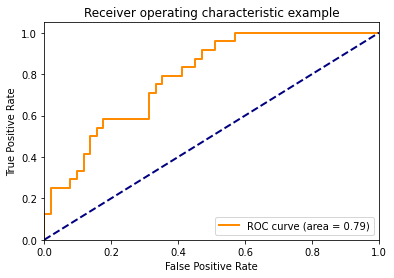

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


### 多分类roc曲线

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


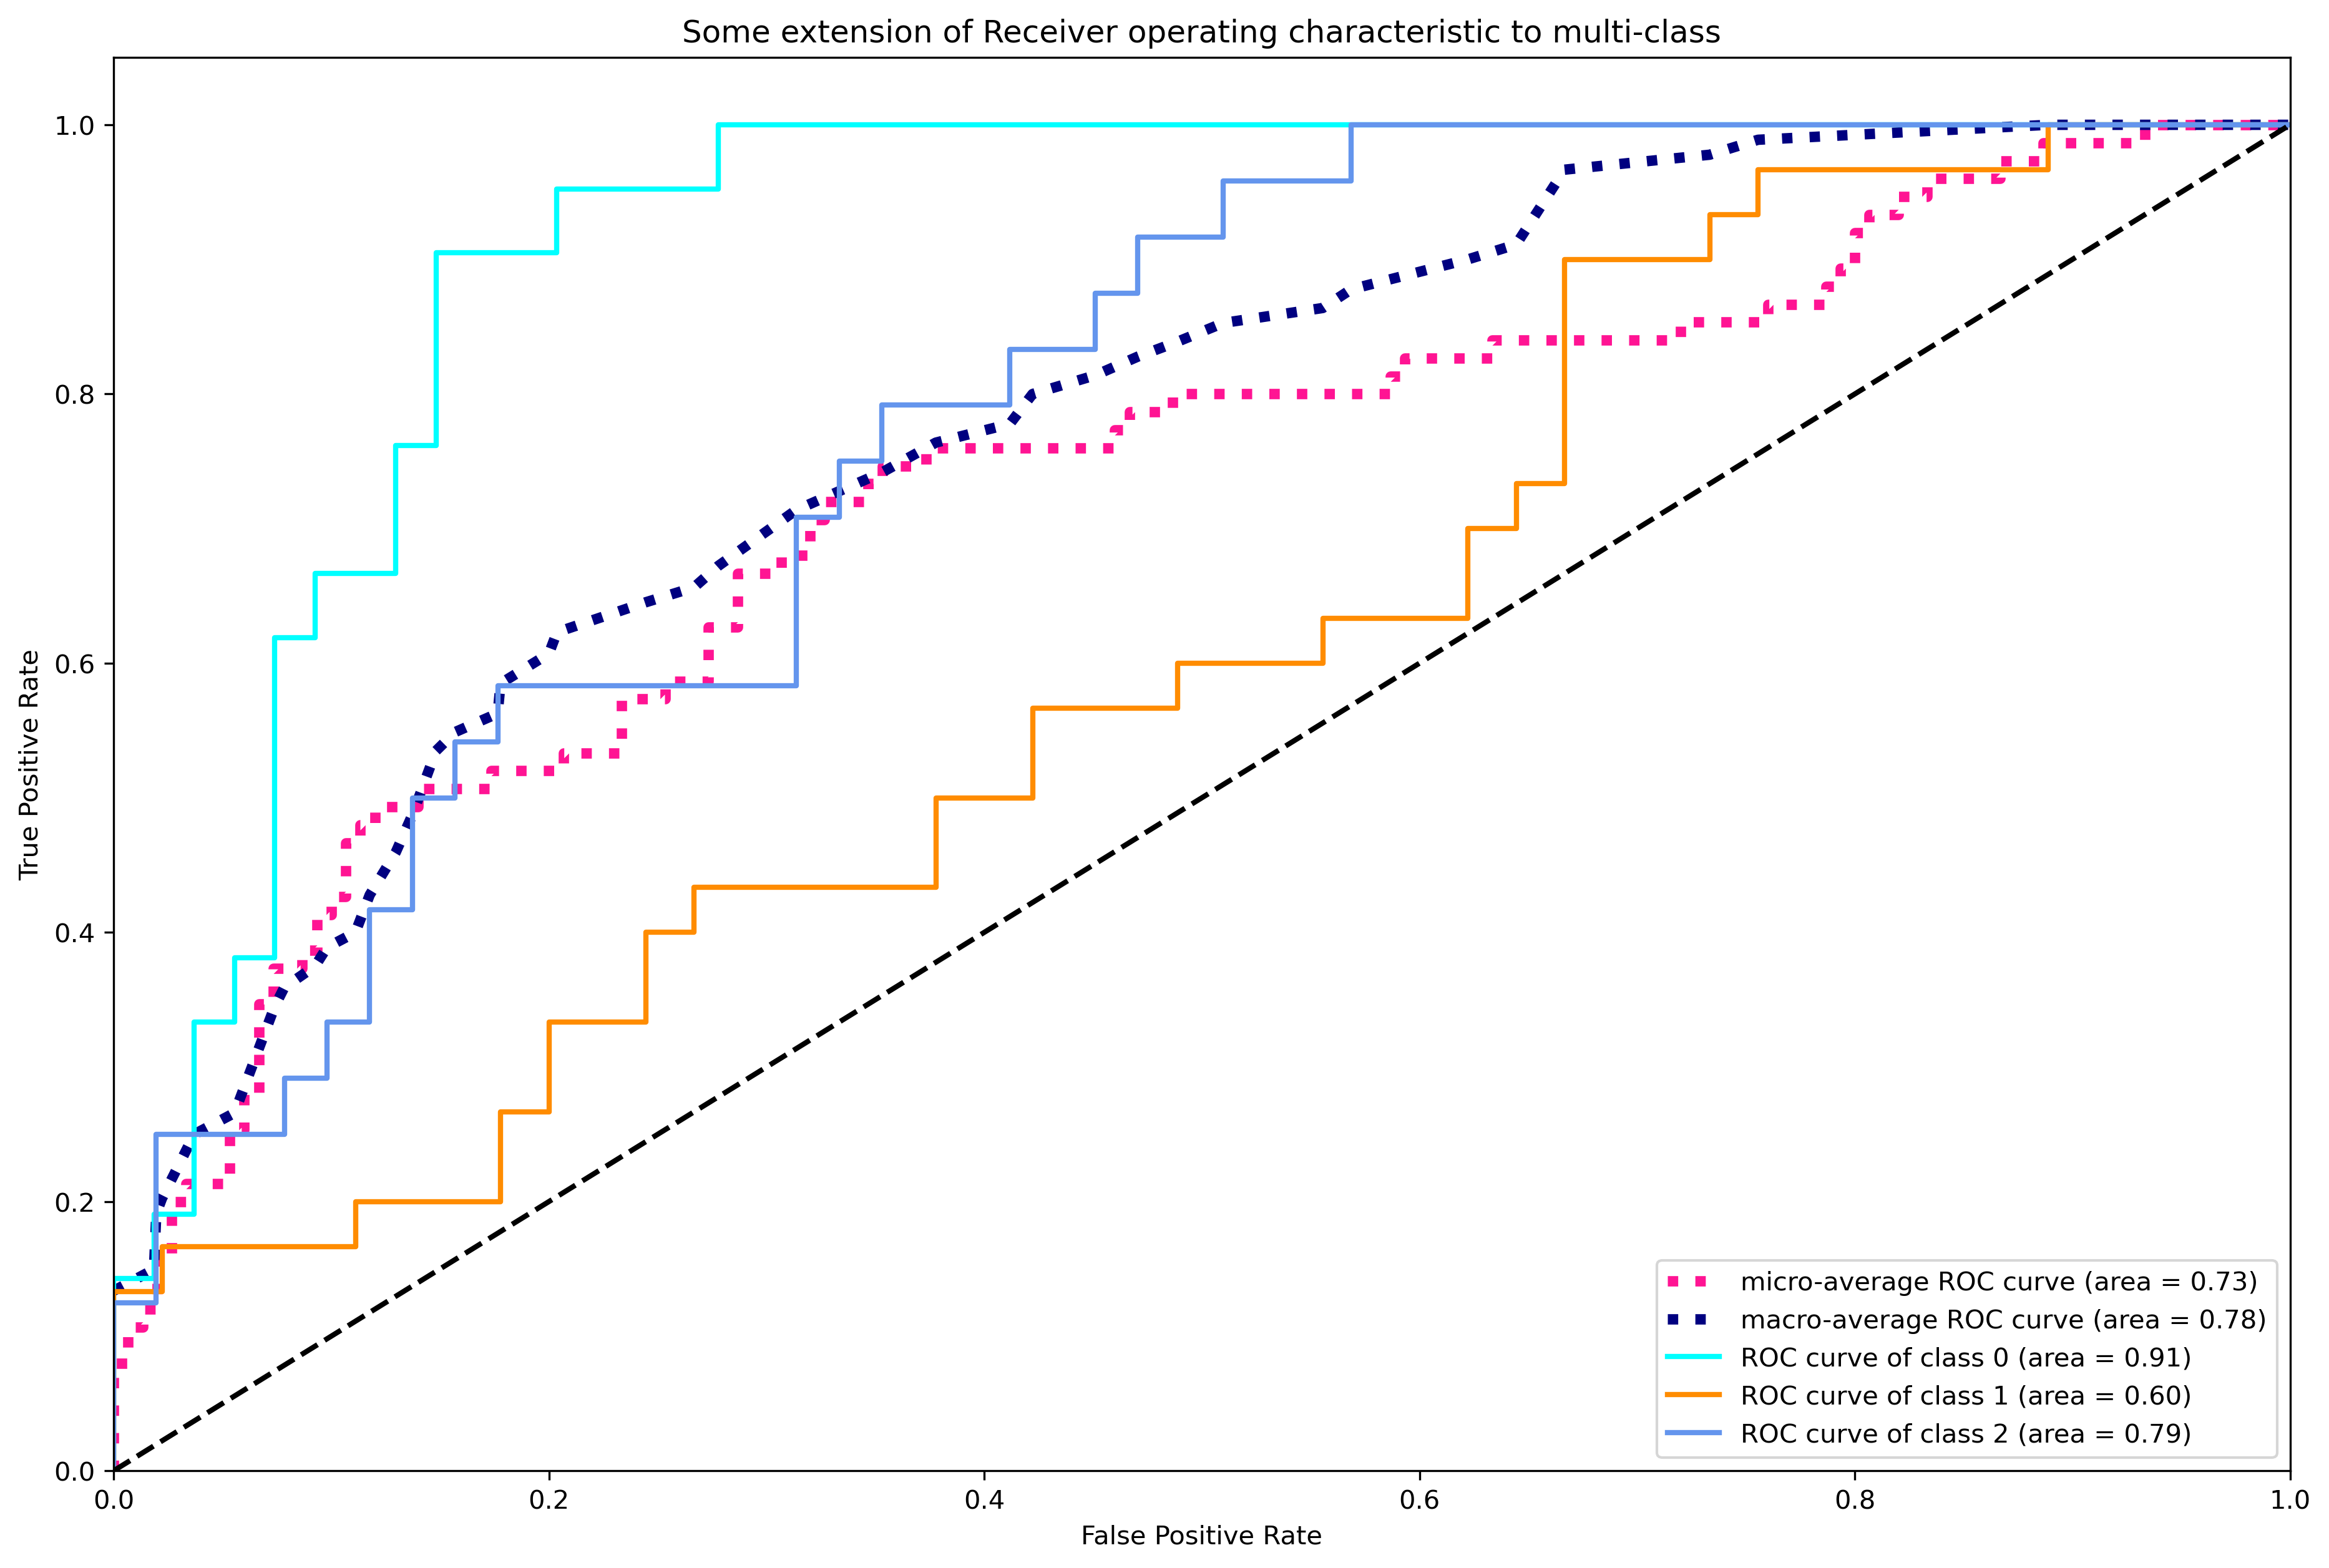

In [7]:

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=300,figsize=(15,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

## 误差分析
当然，如果这是一个实际的项目，你会在你的机器学习项目当中，跟随以下步骤（见附录 B）：探索准备数据的候选方案，尝试多种模型，把最好的几个模型列为入围名单，用GridSearchCV调试超参数，尽可能地自动化，像你前面的章节做的那样。在这里，我们假设你已经找到一个不错的模型，你试图找到方法去改善它。一个方式是分析模型产生的误差的类型。

首先，你可以检查混淆矩阵。你需要使用cross_val_predict()做出预测，然后调用confusion_matrix()函数，像你早前做的那样。

In [52]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5600,    0,   17,    8,    8,   42,   35,    6,  206,    1],
       [   0, 6421,   42,   20,    3,   41,    6,   10,  189,   10],
       [  26,   28, 5291,   84,   64,   25,   67,   35,  329,    9],
       [  26,   24,  122, 5244,    2,  207,   29,   43,  362,   72],
       [  11,   17,   43,   10, 5233,   10,   41,   19,  290,  168],
       [  30,   21,   27,  161,   47, 4519,   80,   20,  449,   67],
       [  31,   17,   46,    2,   49,   85, 5556,    6,  126,    0],
       [  20,   12,   50,   28,   47,   14,    5, 5717,  173,  199],
       [  19,   63,   45,   90,    3,  126,   34,   10, 5416,   45],
       [  25,   22,   29,   60,  130,   36,    1,  170,  335, 5141]],
      dtype=int64)

这里是一对数字。使用 Matplotlib 的matshow()函数，将混淆矩阵以图像的方式呈现，将会更加方便。

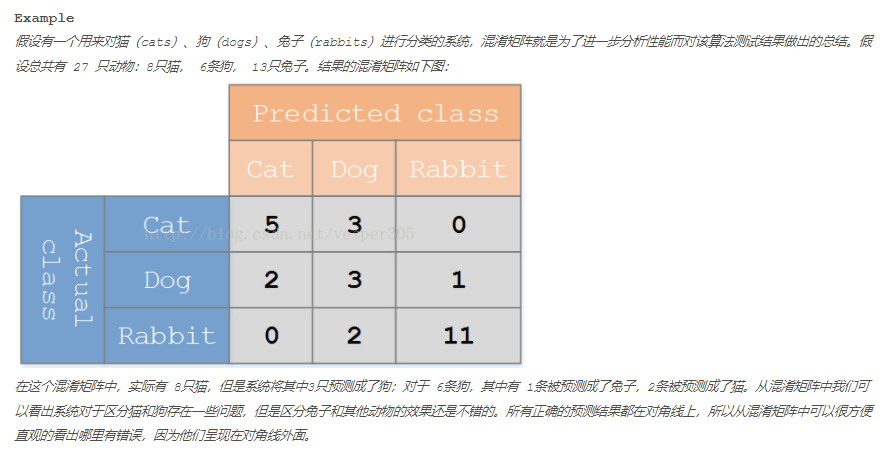

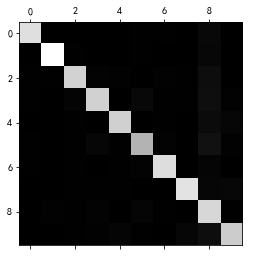

In [53]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

这个混淆矩阵看起来相当好，因为大多数的图片在主对角线上。在主对角线上意味着被分类正确。数字 5 对应的格子看起来比其他数字要暗淡许多。这可能是数据集当中数字 5 的图片比较少，又或者是分类器对于数字 5 的表现不如其他数字那么好。你可以验证两种情况。

让我们关注仅包含误差数据的图像呈现。首先你需要将混淆矩阵的**每一个值除以相应类别的图片的总数目**。这样子，你可以比较**错误率**，而不是绝对的错误数（这对大的类别不公平）。

In [54]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

现在让我们用 0 来填充对角线。这样子就只保留了被错误分类的数据。让我们画出这个结果。

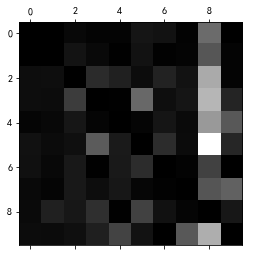

In [55]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

现在你可以清楚看出分类器制造出来的各类误差。记住：行代表实际类别，列代表预测的类别。第 8、9 列相当亮，这告诉你许多图片被误分成数字 8 或者数字 9。相似的，第 8、9 行也相当亮，告诉你数字 8、数字 9 经常被误以为是其他数字。相反，一些行相当黑，比如第一行：这意味着大部分的数字 1 被正确分类（一些被误分类为数字 8 ）。留意到误差图不是严格对称的。举例子，比起将数字 8 误分类为数字 5 的数量，有更多的数字 5 被误分类为数字 8。

分析混淆矩阵通常可以给你提供深刻的见解去改善你的分类器。回顾这幅图，看样子你应该努力改善分类器在数字 8 和数字 9 上的表现，和纠正 3/5 的混淆。比如，你可以尝试去收集更多的数据，或者你可以构造新的、有助于分类器的特征。举例子，写一个算法去数闭合的环（比如，数字 8 有两个环，数字 6 有一个， 5 没有）。又或者你可以预处理图片（比如，使用 Scikit-Learn，Pillow， OpenCV）去构造一个模式，比如闭合的环。

分析独特的误差，是获得关于你的分类器是如何工作及其为什么失败的洞见的一个好途径。但是这相对难和耗时。举例子，我们可以画出数字 3 和 5 的例子

## 多标签分类
到目前为止，所有的样例都总是被分配到仅一个类。有些情况下，你也许想让你的分类器给一个样例输出多个类别。比如说，思考一个人脸识别器。如果对于同一张图片，它识别出几个人，它应该做什么？当然它应该给每一个它识别出的人贴上一个标签。比方说，这个分类器被训练成识别三个人脸，Alice，Bob，Charlie；然后当它被输入一张含有 Alice 和 Bob 的图片，它应该输出[1, 0, 1]（意思是：Alice 是，Bob 不是，Charlie 是）。这种输出多个二值标签的分类系统被叫做多标签分类系统。

目前我们不打算深入脸部识别。我们可以先看一个简单点的例子，仅仅是为了阐明的目的。

In [14]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

这段代码创造了一个y_multilabel数组，里面包含两个目标标签。第一个标签指出这个数字是否为大数字（7，8 或者 9），第二个标签指出这个数字是否是奇数。接下来几行代码会创建一个KNeighborsClassifier样例（它支持多标签分类，但不是所有分类器都可以），然后我们使用多目标数组来训练它。现在你可以生成一个预测，然后它输出两个标签：

In [59]:
some_digit = X_test[5216]
knn_clf.predict([some_digit])

array([[False,  True]])

它工作正确。数字 5 不是大数（False），同时是一个奇数（True）。

有许多方法去评估一个多标签分类器，和选择正确的量度标准，这取决于你的项目。举个例子，一个方法是对每个个体标签去量度 F1 值（或者前面讨论过的其他任意的二分类器的量度标准），然后计算平均值。下面的代码计算全部标签的平均 F1 值：

In [4]:
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average="macro")

这里假设所有标签有着同等的重要性，但可能不是这样。特别是，如果你的 Alice 的照片比 Bob 或者 Charlie 更多的时候，也许你想让分类器在 Alice 的照片上具有更大的权重。一个简单的选项是：给每一个标签的权重等于它的支持度（比如，那个标签的样例的数目）。为了做到这点，简单地在上面代码中设置average="weighted"。

## 多输出分类
我们即将讨论的最后一种分类任务被叫做“多输出-多类分类”（或者简称为多输出分类）。它是多标签分类的简单泛化，在这里每一个标签可以是多类别的（比如说，它可以**有多于两个可能值**）。

为了说明这点，我们建立一个系统，它可以去除图片当中的噪音。它将一张混有噪音的图片作为输入，期待它输出一张干净的数字图片，用一个像素强度的数组表示，就像 MNIST 图片那样。注意到这个分类器的输出是多标签的（一个像素一个标签）和每个标签可以有多个值（像素强度取值范围从 0 到 255）。所以它是一个多输出分类系统的例子。

分类与回归之间的界限是模糊的，比如这个例子。按理说，预测一个像素的强度更类似于一个回归任务，而不是一个分类任务。而且，多输出系统不限于分类任务。你甚至可以让你一个系统给每一个样例都输出多个标签，包括类标签和值标签。

让我们从 MNIST 的图片创建训练集和测试集开始，然后给图片的像素强度添加噪声，这里是用 NumPy 的randint()函数。目标图像是原始图像。

In [12]:
noise = np.random.randint(0, 100, (len(X_train), 784))
noise2 = np.random.randint(0, 100, (len(X_test), 784))
X_train_mod = X_train + noise
X_test_mod = X_test + noise2
y_train_mod = X_train
y_test_mod = X_test

In [15]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

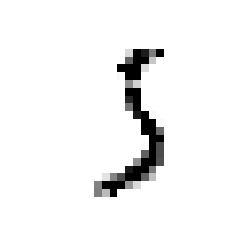

In [16]:
clean_digit = knn_clf.predict([X_test_mod[5216]])
clean_digit_image = clean_digit.reshape(28, 28)
plt.imshow(clean_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()